In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import os
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate

In [7]:
train_csv=pd.read_csv('train.csv')
test_csv=pd.read_csv('test.csv')
print('dataset loaded successfully')

dataset loaded successfully


In [9]:
train_csv.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [11]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
missing_values = train_csv.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

missing_values = test_csv.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
TotalBsmtSF        1


In [15]:
drop_cols = ["PoolQC", "MiscFeature", "Alley", "Fence"]
train_csv.drop(columns=drop_cols, inplace=True)
test_csv.drop(columns=drop_cols, inplace=True)

train_csv.fillna({"PoolQC": "None", "MiscFeature": "None", "Alley": "None", "Fence": "None"}, inplace=True)
test_csv.fillna({"PoolQC": "None", "MiscFeature": "None", "Alley": "None", "Fence": "None"}, inplace=True)                

In [17]:
missing_values = train_csv.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

garage_cols = ["GarageCond", "GarageType", "GarageFinish", "GarageQual"]
basement_cols = ["BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"]
train_csv[garage_cols + basement_cols] = train_csv[garage_cols + basement_cols].fillna("None")
train_csv["GarageYrBlt"].fillna(0, inplace=True)

missing_values = test_csv.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

garage_cols = ["GarageCond", "GarageType", "GarageFinish", "GarageQual"]
basement_cols = ["BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"]
test_csv[garage_cols + basement_cols] = test_csv[garage_cols + basement_cols].fillna("None")
test_csv["GarageYrBlt"].fillna(0, inplace=True)

MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageCond       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
Electrical        1
dtype: int64
MasVnrType      894
FireplaceQu     730
LotFrontage     227
GarageYrBlt      78
GarageFinish     78
GarageQual       78
GarageCond       78
GarageType       76
BsmtCond         45
BsmtQual         44
BsmtExposure     44
BsmtFinType1     42
BsmtFinType2     42
MasVnrArea       15
MSZoning          4
BsmtHalfBath      2
Utilities         2
Functional        2
BsmtFullBath      2
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
KitchenQual       1
Exterior2nd       1
Exterior1st       1
GarageArea        1
SaleType          1
GarageCars        1
dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_1624\59019285.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_csv["GarageYrBlt"].fillna(0, inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_1624\59019285.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [19]:
train_csv["LotFrontage"] = train_csv.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test_csv["LotFrontage"] = test_csv.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [21]:
train_csv["MasVnrType"].fillna("None", inplace=True)
train_csv["MasVnrArea"].fillna(0, inplace=True)
test_csv["MasVnrType"].fillna("None", inplace=True)
test_csv["MasVnrArea"].fillna(0, inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_1624\564868353.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_csv["MasVnrType"].fillna("None", inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_1624\564868353.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [23]:
train_csv["FireplaceQu"].fillna("None", inplace=True)
train_csv["Electrical"].fillna(train_csv["Electrical"].mode()[0], inplace=True)
print(train_csv.isnull().sum().sum()) 

test_csv["FireplaceQu"].fillna("None", inplace=True)
test_csv["Electrical"].fillna(test_csv["Electrical"].mode()[0], inplace=True)
print(test_csv.isnull().sum().sum()) 

0
22


C:\Users\admin\AppData\Local\Temp\ipykernel_1624\3361887528.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_csv["FireplaceQu"].fillna("None", inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_1624\3361887528.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [27]:
cat_cols = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", 
            "KitchenQual", "Functional", "SaleType"]

for col in cat_cols:
    test_csv[col].fillna(test_csv[col].mode()[0], inplace=True)  # Fill with most common value



C:\Users\admin\AppData\Local\Temp\ipykernel_1624\3162744030.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_csv[col].fillna(test_csv[col].mode()[0], inplace=True)  # Fill with most common value


In [29]:
num_cols = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
            "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]

for col in num_cols:
    test_csv[col].fillna(test_csv[col].median(), inplace=True)  # Fill with median value


C:\Users\admin\AppData\Local\Temp\ipykernel_1624\2562014263.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_csv[col].fillna(test_csv[col].median(), inplace=True)  # Fill with median value


In [31]:
print(test_csv.isnull().sum().sum())  # Should print 0 if all missing values are handled


0


In [33]:
train_csv.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.199658,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.431902,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


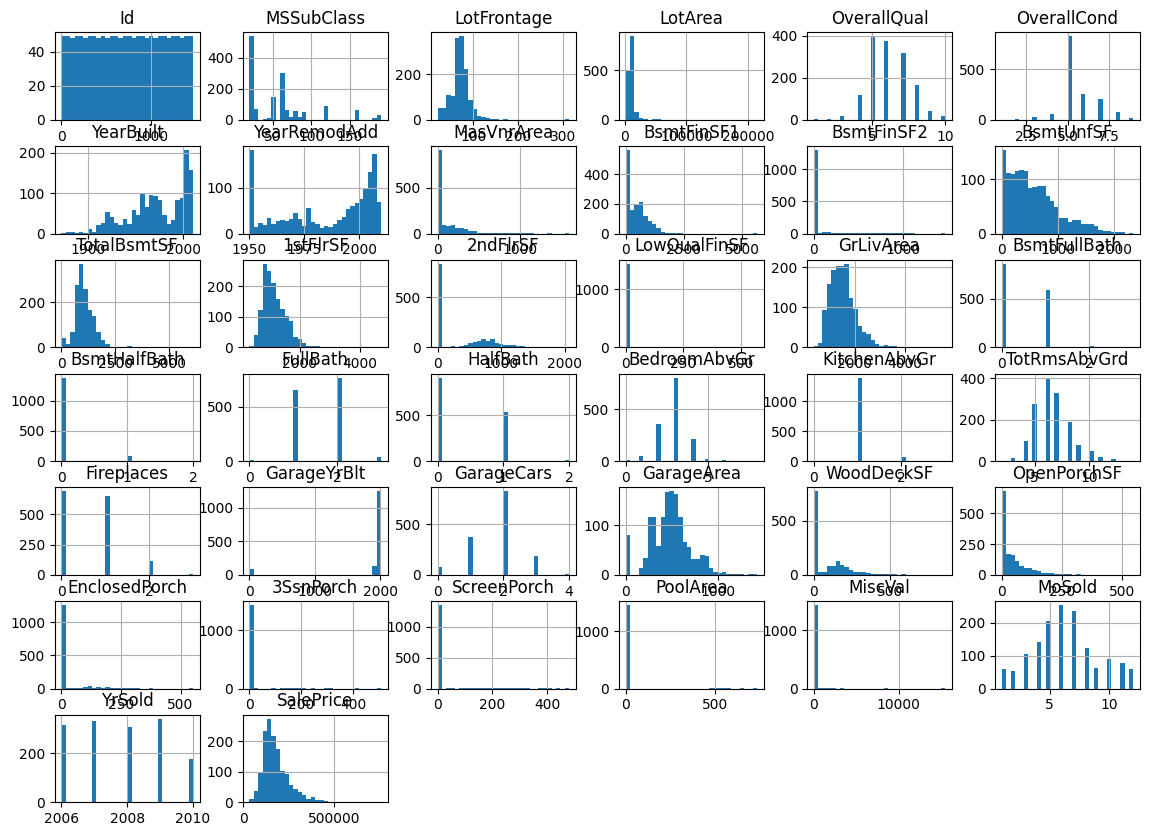

In [35]:
train_csv.hist(figsize=(14, 10), bins=30)
plt.show()

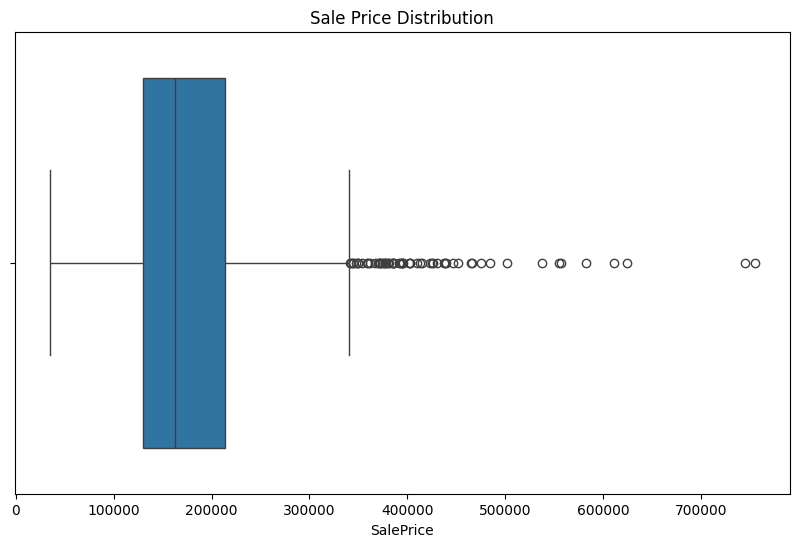

In [114]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_csv["SalePrice"])
plt.title("Sale Price Distribution")
plt.show()

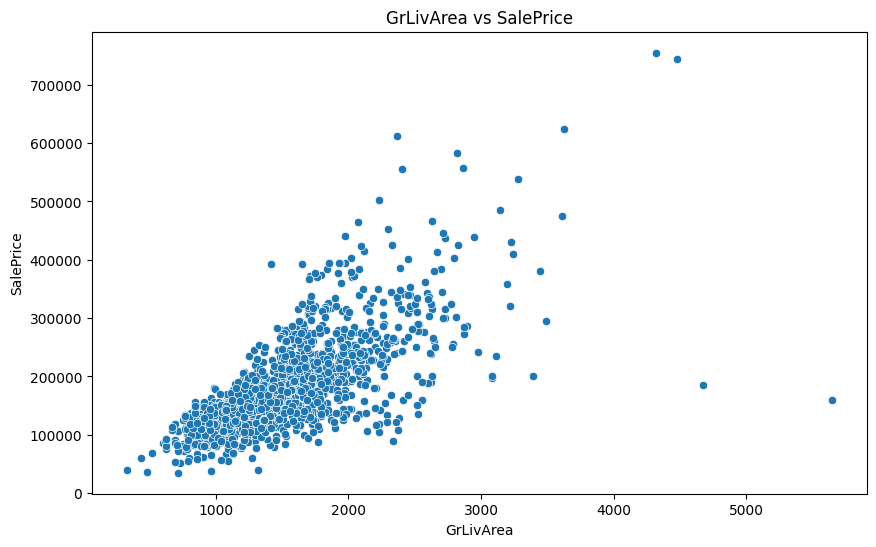

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_csv["GrLivArea"], y=train_csv["SalePrice"])
plt.title("GrLivArea vs SalePrice")
plt.show()

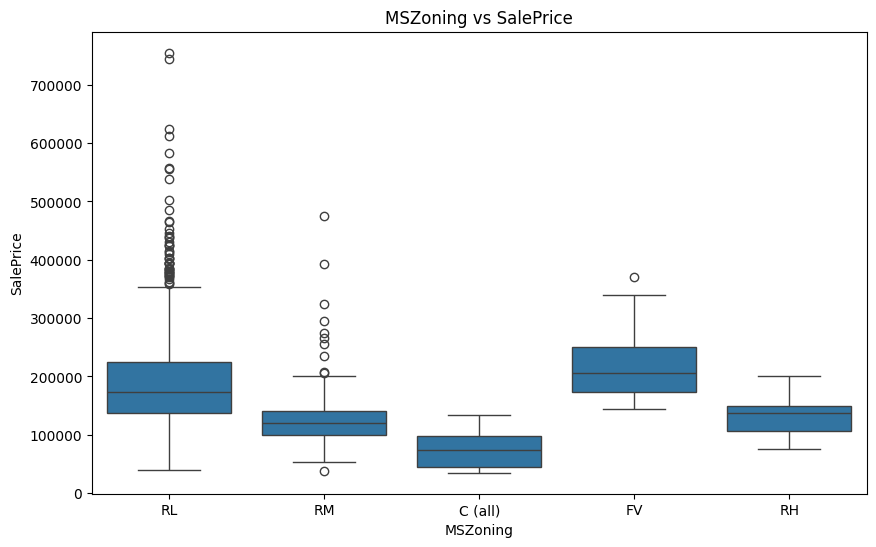

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_csv["MSZoning"], y=train_csv["SalePrice"])
plt.title("MSZoning vs SalePrice")
plt.show()

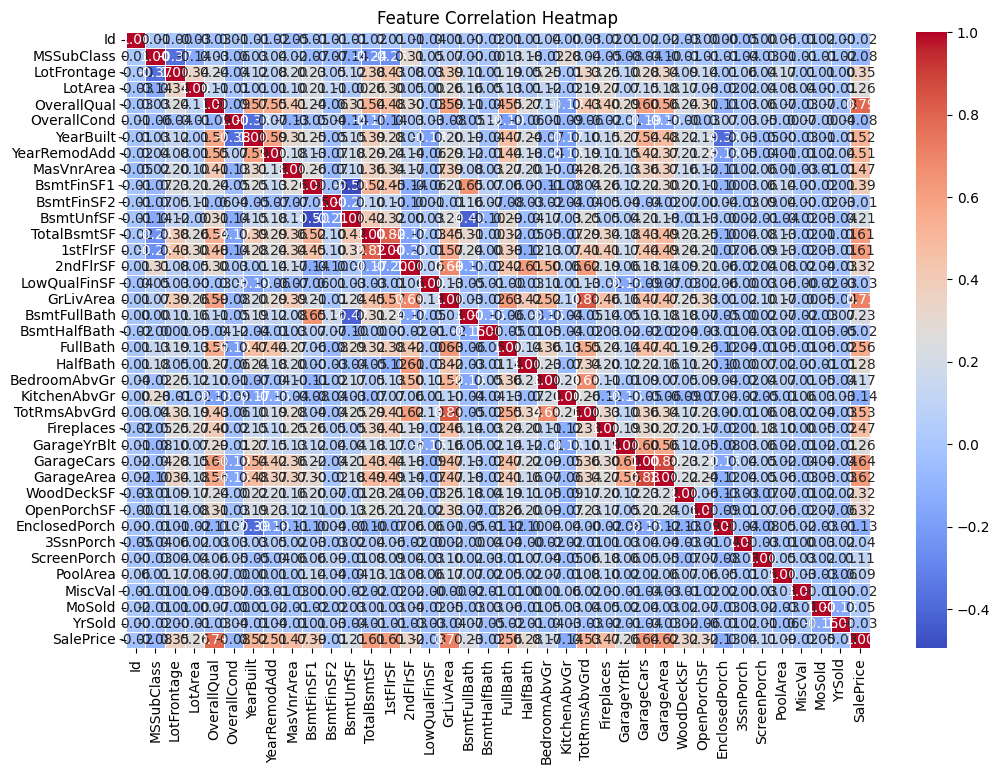

In [41]:
# Select only numerical columns for correlation
numeric_cols = train_csv.select_dtypes(include=['number'])
corr_matrix = numeric_cols.corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [43]:
from scipy.stats import zscore

# Compute Z-score
z_scores = zscore(train_csv.select_dtypes(include=['number']))
outliers = (abs(z_scores) > 3).sum()

print("Outlier count per feature:\n", outliers)

from scipy.stats import zscore

# Compute Z-score
z_scores = zscore(test_csv.select_dtypes(include=['number']))
outliers = (abs(z_scores) > 3).sum()

print("Outlier count per feature:\n", outliers)



Outlier count per feature:
 Id                0
MSSubClass       30
LotFrontage      15
LotArea          13
OverallQual       2
OverallCond      28
YearBuilt         6
YearRemodAdd      0
MasVnrArea       32
BsmtFinSF1        6
BsmtFinSF2       50
BsmtUnfSF        11
TotalBsmtSF      10
1stFlrSF         12
2ndFlrSF          4
LowQualFinSF     20
GrLivArea        16
BsmtFullBath     16
BsmtHalfBath     82
FullBath          0
HalfBath         12
BedroomAbvGr     14
KitchenAbvGr     68
TotRmsAbvGrd     12
Fireplaces        5
GarageYrBlt      81
GarageCars        0
GarageArea        7
WoodDeckSF       22
OpenPorchSF      27
EnclosedPorch    51
3SsnPorch        23
ScreenPorch      55
PoolArea          7
MiscVal           8
MoSold            0
YrSold            0
SalePrice        22
dtype: int64
Outlier count per feature:
 Id                0
MSSubClass       31
LotFrontage      12
LotArea          17
OverallQual       2
OverallCond      30
YearBuilt         2
YearRemodAdd      0
MasVnrArea 

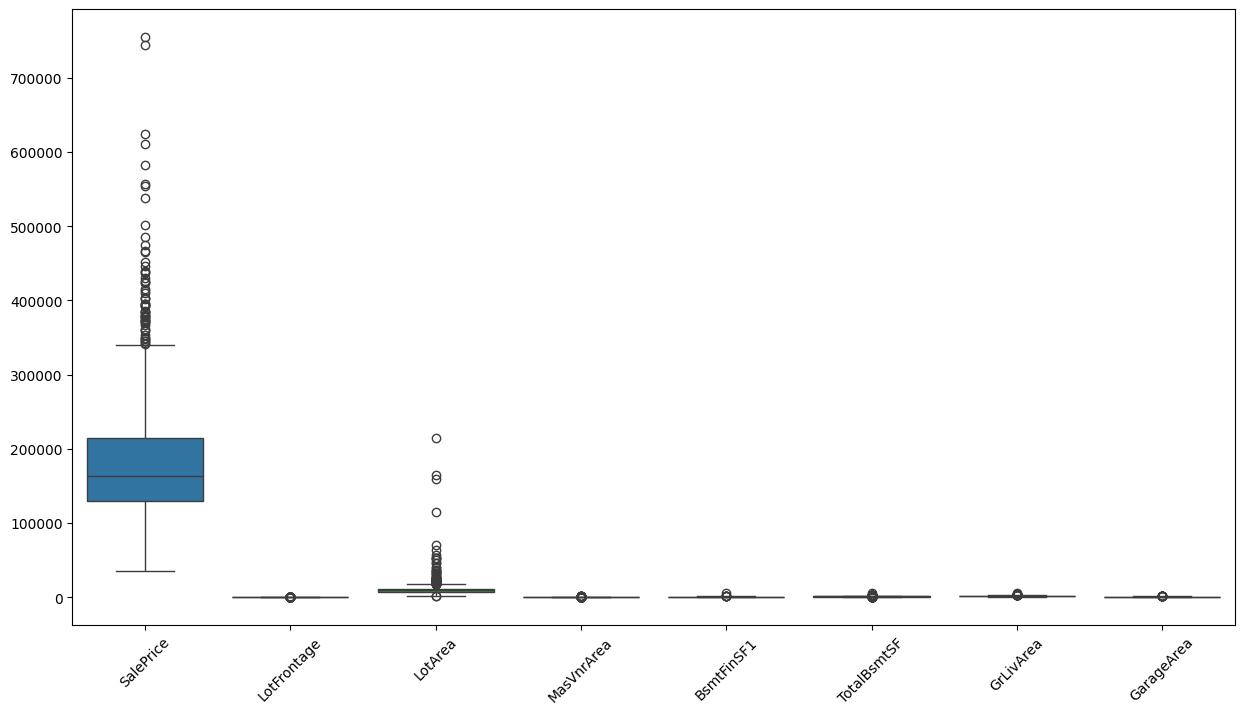

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.boxplot(data=train_csv[['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 
                            'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']])
plt.xticks(rotation=45)
plt.show()

In [47]:
import numpy as np

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Check outliers for SalePrice
outliers = detect_outliers_iqr(train_csv, 'SalePrice')
print(outliers)


        Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
11      12          60       RL         85.0    11924   Pave      IR1   
53      54          20       RL         68.0    50271   Pave      IR1   
58      59          60       RL         66.0    13682   Pave      IR2   
112    113          60       RL         77.0     9965   Pave      Reg   
151    152          20       RL        107.0    13891   Pave      Reg   
...    ...         ...      ...          ...      ...    ...      ...   
1268  1269          50       RL         74.0    14100   Pave      IR1   
1353  1354          50       RL         56.0    14720   Pave      IR1   
1373  1374          20       RL         91.0    11400   Pave      Reg   
1388  1389          20       RL         42.0    14892   Pave      IR1   
1437  1438          20       RL         96.0    12444   Pave      Reg   

     LandContour Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch  \
11           Lvl    AllPub    Inside  ... 

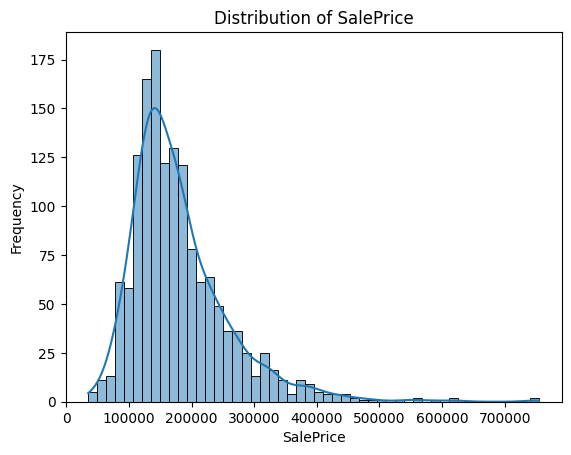

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_csv['SalePrice'], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

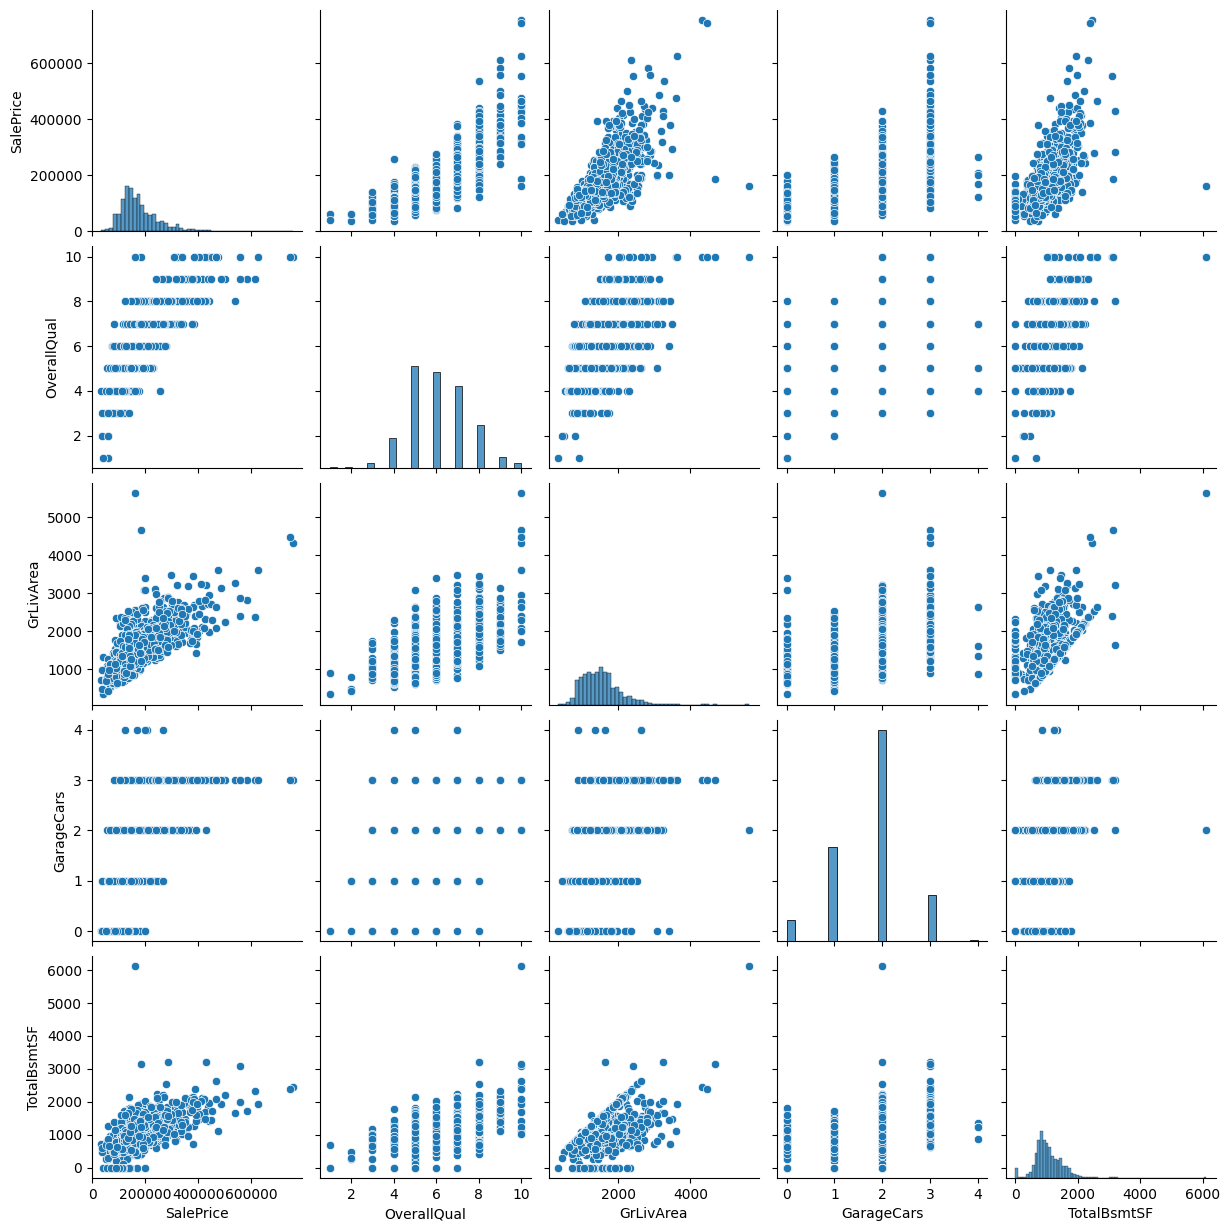

In [146]:
important_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(train_csv[important_features])
plt.show()

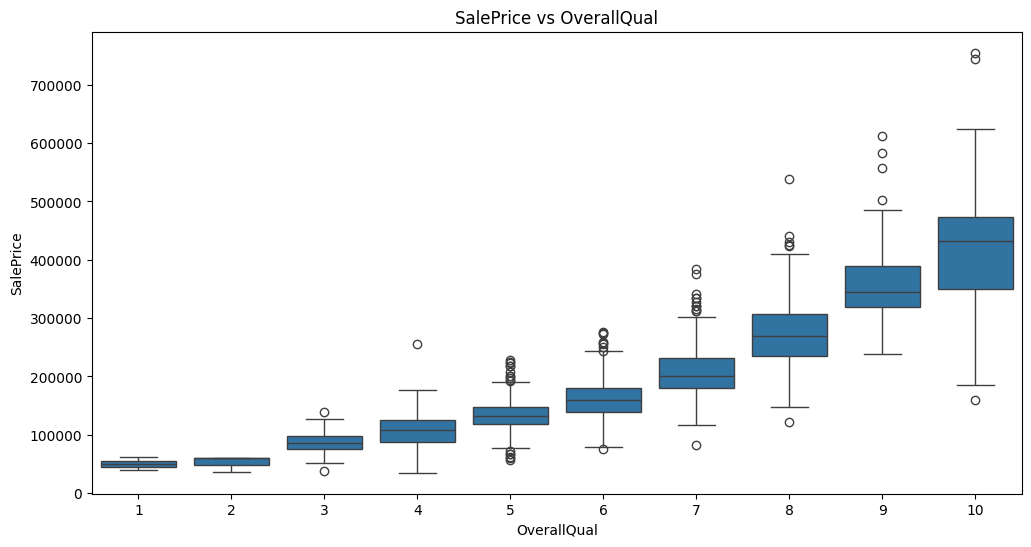

In [148]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="OverallQual", y="SalePrice", data=train_csv)
plt.title("SalePrice vs OverallQual")
plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


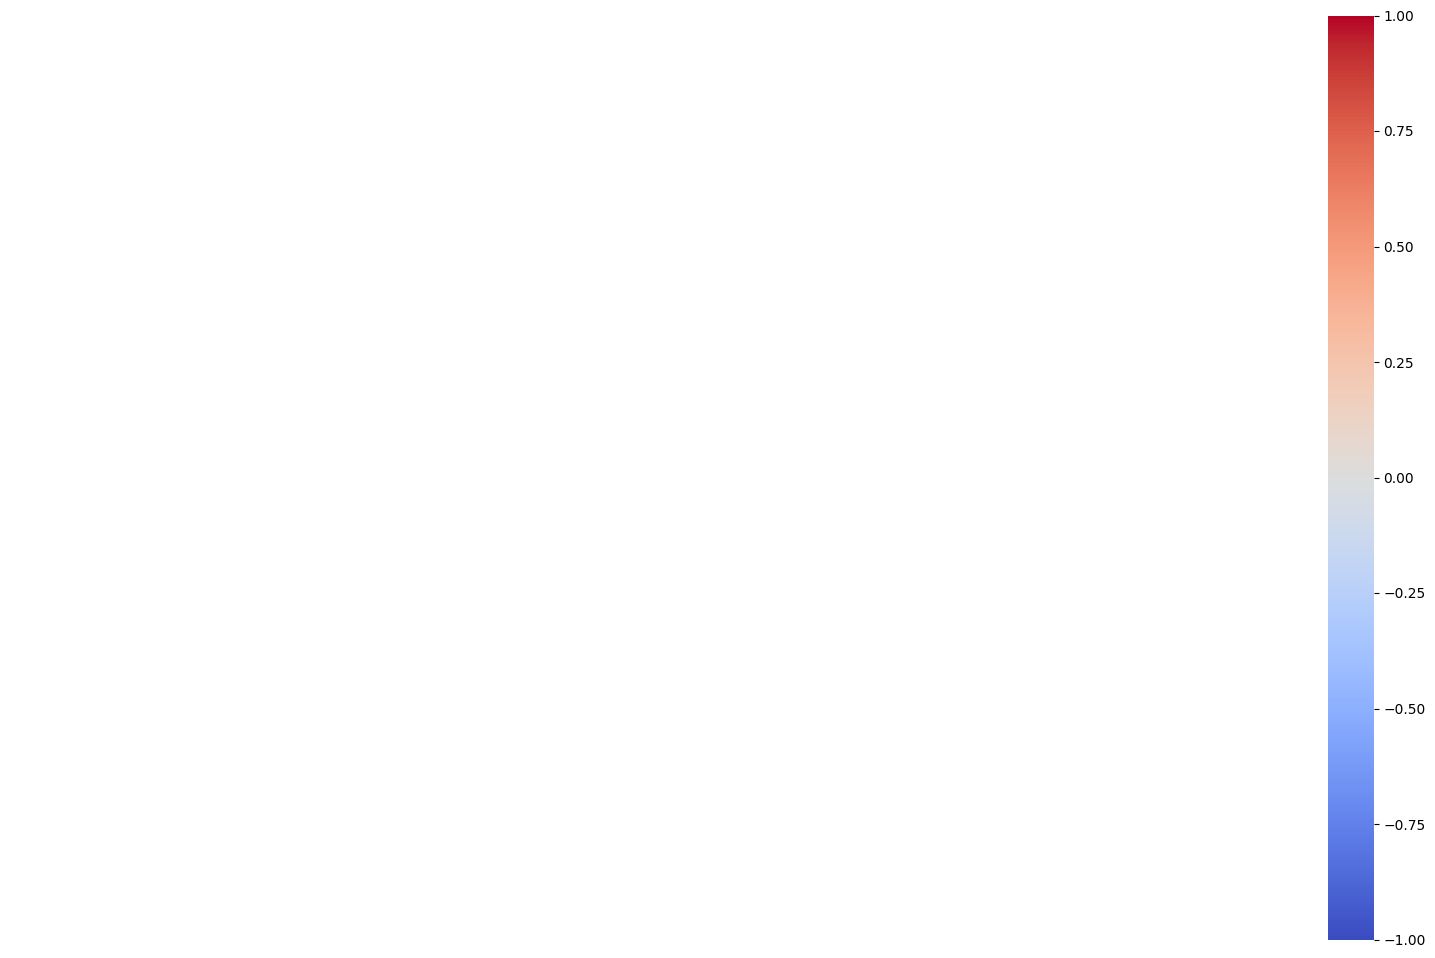

In [51]:
import missingno as msno

msno.heatmap(train_csv, cmap="coolwarm")
plt.show()

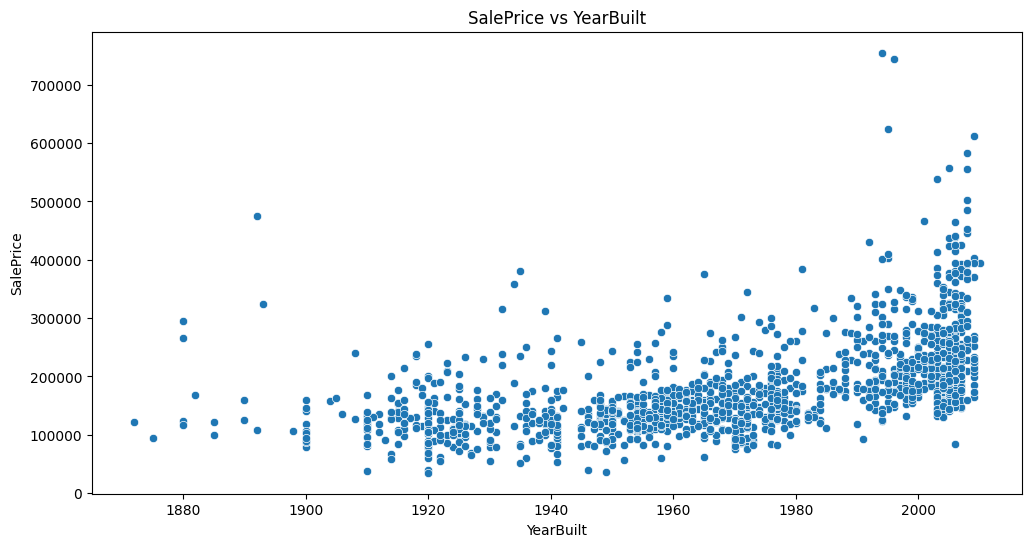

In [53]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="YearBuilt", y="SalePrice", data=train_csv)
plt.title("SalePrice vs YearBuilt")
plt.show()


In [77]:
# Fill missing values only in numeric columns
train_csv.fillna(train_csv.select_dtypes(include=['number']).median(), inplace=True)


In [79]:
# Fill categorical columns with mode (most frequent value)
for col in train_csv.select_dtypes(include=['object']).columns:
    train_csv[col].fillna(train_csv[col].mode()[0], inplace=True)


C:\Users\admin\AppData\Local\Temp\ipykernel_1624\3208968988.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_csv[col].fillna(train_csv[col].mode()[0], inplace=True)


In [81]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in train_csv.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_csv[col] = le.fit_transform(train_csv[col])
    label_encoders[col] = le  # Save encoders for later decoding if needed


In [83]:
train_csv = pd.get_dummies(train_csv, drop_first=True)


In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_csv[train_csv.select_dtypes(include=['number']).columns] = scaler.fit_transform(train_csv.select_dtypes(include=['number']))


In [87]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_csv[train_csv.select_dtypes(include=['number']).columns] = scaler.fit_transform(train_csv.select_dtypes(include=['number']))


In [93]:
from sklearn.model_selection import train_test_split

X = train_csv.drop(columns=['SalePrice'])  # 'SalePrice' is the target variable
y = train_csv['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [97]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 0.024480419433754445
Mean Squared Error (MSE): 0.0015713015943001906
Root Mean Squared Error (RMSE): 0.03963964674792386
R² Score: 0.8937738751105065


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


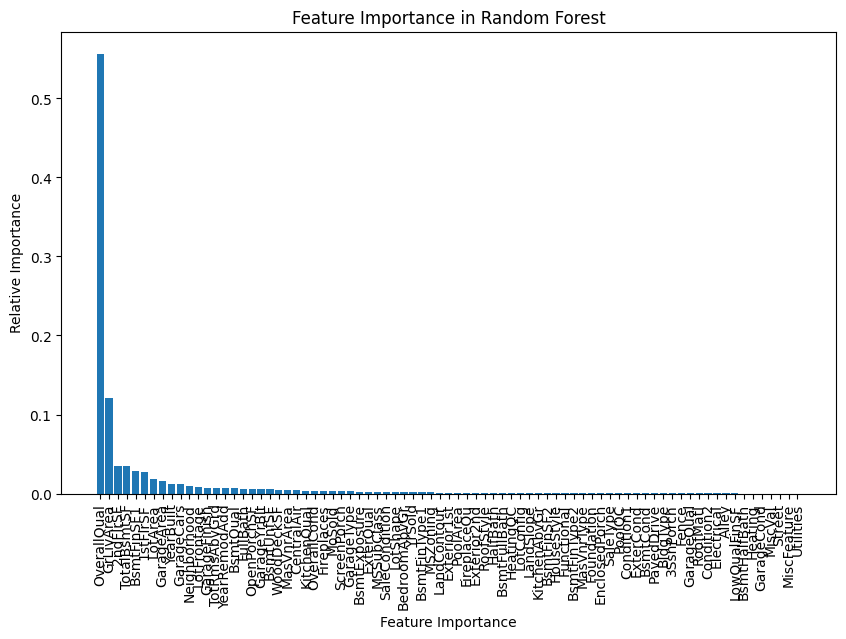

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel("Feature Importance")
plt.ylabel("Relative Importance")
plt.title("Feature Importance in Random Forest")
plt.show()


In [103]:
import joblib
joblib.dump(model, "random_forest_model.pkl")
loaded_model = joblib.load("random_forest_model.pkl")

In [111]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [113]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [115]:
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

In [117]:
models = {
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
}

In [119]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3102
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 72
[LightGBM] [Info] Start training from score 0.203502


In [121]:
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

for model, metrics in results.items():
    print(f"\n{model} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Performance:
MAE: 0.02435473471528103
MSE: 0.001544781257426239
RMSE: 0.03930370539053842
R2: 0.8955667534650522

XGBoost Performance:
MAE: 0.022763495379769728
MSE: 0.001260773240190137
RMSE: 0.035507368815361935
R2: 0.9147668046951765

LightGBM Performance:
MAE: 0.023221092550444758
MSE: 0.0016859574135633488
RMSE: 0.04106041175589145
R2: 0.8860226939110885

Gradient Boosting Performance:
MAE: 0.023544145702533315
MSE: 0.0013642307223274705
RMSE: 0.036935494071793196
R2: 0.9077726748233949


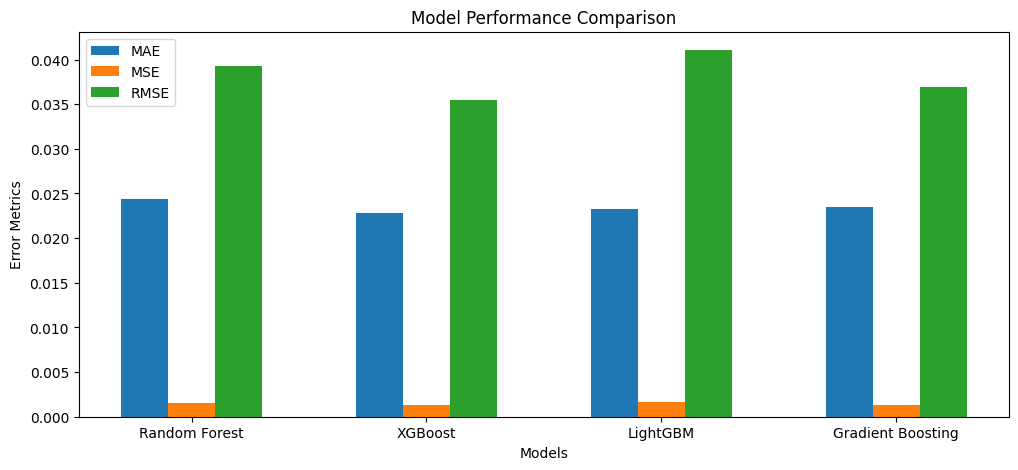

In [123]:
models = ["Random Forest", "XGBoost", "LightGBM", "Gradient Boosting"]
mae = [0.02435, 0.02276, 0.02322, 0.02354]
mse = [0.00154, 0.00126, 0.00169, 0.00136]
rmse = [0.0393, 0.0355, 0.04106, 0.03693]
r2 = [0.8956, 0.9148, 0.8860, 0.9078]


fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(models))
width = 0.2

ax.bar(x - width, mae, width, label="MAE")
ax.bar(x, mse, width, label="MSE")
ax.bar(x + width, rmse, width, label="RMSE")

ax.set_xlabel("Models")
ax.set_ylabel("Error Metrics")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_1624\1501467870.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2, palette="viridis")


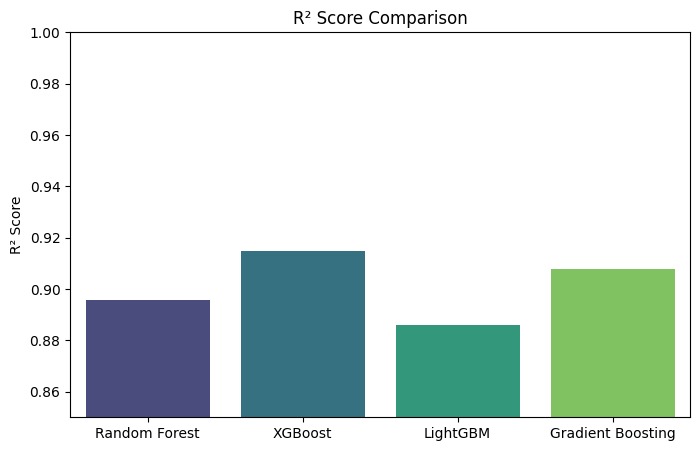

In [125]:
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=r2, palette="viridis")
plt.ylabel("R² Score")
plt.title("R² Score Comparison")
plt.ylim(0.85, 1)
plt.show()

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [131]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [137]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(100, activation='relu'),
    Dense(80, activation='relu'),
    Dense(60, activation='relu'),
    Dense(40, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1)  
])

model.summary()

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 60)             │         4,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,361 (153.75 KB)

 Trainable params: 39,361 (153.75 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [141]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0192 - mae: 0.0958 - val_loss: 0.0056 - val_mae: 0.0527
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0390 - val_loss: 0.0048 - val_mae: 0.0494
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0326 - val_loss: 0.0036 - val_mae: 0.0429
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0038 - val_mae: 0.0420
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6552e-04 - mae: 0.0218 - val_loss: 0.0033 - val_mae: 0.0400
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - mae: 0.0213 - val_loss: 0.0033 - val_mae: 0.0386
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8129e-04 - mae: 0.0166 - val_loss: 0.0032 - val_mae: 0.0387
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5147e-04 - mae: 0.0141 - val_loss: 0.0030 - val_mae: 0.0373
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [143]:
y_pred_ann = model.predict(X_test_scaled).flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [145]:
mae_ann = mean_absolute_error(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test, y_pred_ann)

In [147]:
print("ANN Performance:")
print(f"MAE: {mae_ann}")
print(f"MSE: {mse_ann}")
print(f"RMSE: {rmse_ann}")
print(f"R² Score: {r2_ann}")

ANN Performance:
MAE: 0.02828391881049614
MSE: 0.0019388831469306534
RMSE: 0.04403275084446409
R² Score: 0.8689239264701962


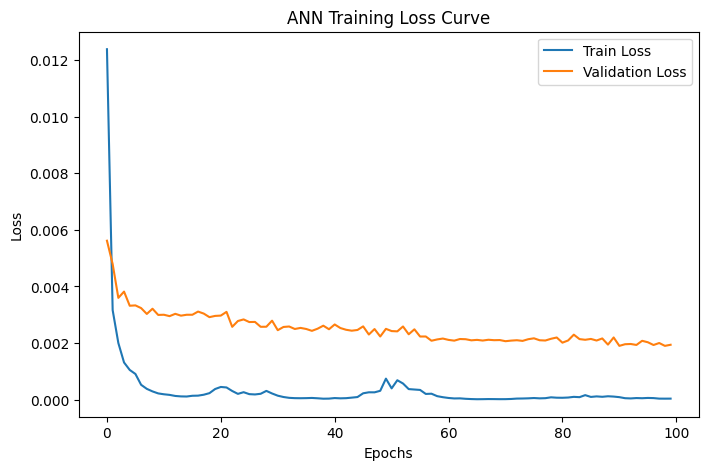

In [149]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ANN Training Loss Curve')
plt.legend()
plt.show()

In [153]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [155]:
import joblib
joblib.dump(xgb_model, "best_model_xgboost.pkl")
print(" XGBoost model saved successfully!")

 XGBoost model saved successfully!


In [157]:
loaded_model = joblib.load("best_model_xgboost.pkl")
y_pred_best = loaded_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print("Best Model (XGBoost) Performance:")
print(f"MAE: {mae_best}")
print(f"MSE: {mse_best}")
print(f"RMSE: {rmse_best}")
print(f"R² Score: {r2_best}")


Best Model (XGBoost) Performance:
MAE: 0.02279606112662068
MSE: 0.0012667524727515997
RMSE: 0.03559146629111534
R² Score: 0.9143625852206203


In [159]:
print(X_train.shape[1])  # This should return 79


79


In [161]:
print(X_train.columns.tolist())


['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [165]:
categorical_cols = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'GarageType', 'PavedDrive']

for col in categorical_cols:
    train_csv[col] = train_csv[col].astype('category')


In [167]:
import xgboost as xgb

model = xgb.XGBRegressor(enable_categorical=True)
